## Bernoulli Naive Bayes Model

We construct a pipeline incorporating a Bernoulli Naive Bayes model (coded from scratch) to classify the data. The data is pre-processed as outlined in our paper at four different levels for comparison: 'basic', 'common_words', 'mutual', and 'word_replacement'. A 5-fold cross validation is used to determine an average accuracy across the training set.

In [1]:
import sys
sys.path.append('../')

from prep import *
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from BernoulliNaiveBayes import BernoulliNaiveBayes
from sklearn.metrics import accuracy_score

# Load data
df = pd.read_csv('../../Datasets/train.csv', encoding='cp1252')

# Do some basic cleaning
df = prep_data(df)

processing = 'none'

if processing in ['basic', 'common_words', 'mutual', 'word_replacement']:
    df = prep_data(df)

# Split data using KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define pipeline
model = BernoulliNaiveBayes(alpha=0.1)
vectorizer = CountVectorizer(max_features=3000)

# Make list to store accuracies
test_acc = []
y_preds = []
y_vals = []

# Iterate through folds
for train_index, val_index in kf.split(df):
    # Split data
    train = df.iloc[train_index]
    val = df.iloc[val_index]
    vocab = build_vocab(train)

    if processing in ['word_replacement']:
        val = word_replacement(val)
        train = word_replacement(train)

    # Reduce features based on mutual information
    subreddits = ['Toronto', 'London', 'Paris', 'Montreal']

    if processing in ['common_words', 'mutual', 'word_replacement']:
        train, vocab = remove_common_words(train, subreddits, 300)

    if processing in ['mutual', 'word_replacement']:
        train = mutual_info_transform(train, 3250)
        train, vocab = remove_common_words(train, subreddits, 25)

    # Remove words not in vocab from val
    val['body'] = val['body'].apply(lambda x: ' '.join([word for word in x.split() if word in vocab]))

    # Split into X and y
    X_train = train['body']
    y_train = train['subreddit']
    y_train = y_train.map({'Toronto': 0, 'London': 1, 'Paris': 2, 'Montreal': 3})
    X_val = val['body']
    y_val = val['subreddit']
    y_val = y_val.map({'Toronto': 0, 'London': 1, 'Paris': 2, 'Montreal': 3})

    # Perform vectorizations
    x_train = vectorizer.fit_transform(X_train).toarray()
    x_val = vectorizer.transform(X_val).toarray()

    # Fit model
    model.fit(x_train, y_train)

    # Evaluate on validation set
    y_vals.extend(y_val)
    y_preds.extend(model.predict(x_val))
    test_acc.append(accuracy_score(y_val, model.predict(x_val)))

    # Print accuracy
    print(f'Accuracy: {test_acc[-1]}')

test_acc = np.mean(test_acc)
print(f'Average accuracy: {test_acc}')

Accuracy: 0.6875
Accuracy: 0.6597222222222222
Accuracy: 0.6180555555555556
Accuracy: 0.6458333333333334
Accuracy: 0.6433566433566433
Average accuracy: 0.6508935508935509


To better analyze the shortcomings of the model, we plot a confusion matrix. The ensemble model shows good performance in classifying Reddit posts from the "Toronto", "London", and "Paris" subreddit communities, though struggles somewhat with "Montreal". This is a common issue across all models for various reasons outlined in our paper.

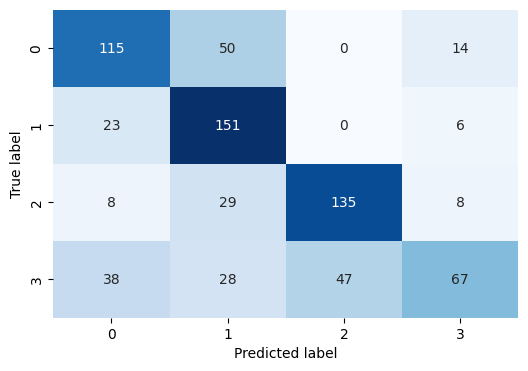

In [2]:
from prep import plot_conf_mat
from sklearn.metrics import confusion_matrix

# Plot overall confusion matrix with proper city names
conf_mat = confusion_matrix(y_vals, y_preds)
plot_conf_mat(conf_mat)

Finally, the model is used on unseen test data from Kaggle. The Kaggle data is pre-processed in the same manner as the training set.

In [3]:
# Retrain on full dataset and test on Kaggle test set
kaggle_test = pd.read_csv('../../Datasets/Kaggle/test.csv', encoding='cp1252')
test_body = kaggle_test['body'].copy()
kaggle_test = prep_data(kaggle_test)
kaggle_test = word_replacement(kaggle_test)

test_df = df.copy()

# Reduce features based on mutual information
subreddits = ['Toronto', 'London', 'Paris', 'Montreal']
test_df = word_replacement(test_df)
test_df, _ = remove_common_words(test_df, subreddits, 300)
test_df = mutual_info_transform(test_df, 3250)
test_df, vocab = remove_common_words(test_df, subreddits, 25)

# Remove words not in vocab from kaggle test set
kaggle_test['body'] = kaggle_test['body'].apply(lambda x: ' '.join([word for word in x.split() if word in vocab]))

# Split into X and y
X_train = test_df['body']
y_train = test_df['subreddit']

# Perform vectorizations
X_train = vectorizer.fit_transform(X_train).toarray()

# Fit on full training set
model.fit(X_train, y_train)

# Make predictions on test set
X_test = kaggle_test['body']

# Perform vectorizations
X_test = vectorizer.transform(X_test).toarray()
y_pred = model.predict(X_test)

'''# Make submission file
submission = generate_kaggle_submission(kaggle_test, y_pred)
submission.to_csv('../../Datasets/Kaggle/submission.csv', index=False)'''

"# Make submission file\nsubmission = generate_kaggle_submission(kaggle_test, y_pred)\nsubmission.to_csv('../../Datasets/Kaggle/submission.csv', index=False)"